In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.stack_fun import cyrillic_to_latin, check_overfitting, cross_validation_regressor, \
    calibrate_predictions, plot_residuals_vs_predictions, StackingRegressorCV, \
    fill_mode_group_by, fill_missing_values
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.inspection import permutation_importance

from lightgbm import LGBMRegressor
from lightgbm import early_stopping
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor
from transliterate import translit

from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_timeline
from optuna.terminator import report_cross_validation_scores

from src.get_metrics import get_metrics_regression, rmsle, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import optuna
import shap

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)


RAND = 25
N_FOLDS = 5

## Tuning and Ensemble Learning

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
dataset_path = os.path.join(parent_dir, "data", "df_base.csv")

In [3]:
# Loading data
df = pd.read_csv(dataset_path, index_col=0)

#### **Goal:**  
To create a more robust and accurate model by combining the best qualities of different algorithms through tuning and ensemble learning.

We will use the same set of features as the baseline models for tuning and ensemble learning:

#### **Features:**
1. **price**: The property price.  
2. **district_value**: City district.  
3. **address_value**: Postal address.  
4. **house_type_value**: Type of building.  
5. **apartment_type**: Type of apartment.  
6. **renovation**: Renovation type.  
7. **area_documents**: Documented area.  
8. **floor**: Floor number.  
9. **balcony_loggia**: Presence of a balcony/loggia.  
10. **construction_status**: Building status (completed/not completed).  
11. **mortgage**: Mortgage suitability (yes/no).  
12. **year**: Year of construction.  
13. **building_age**: Age of the building in years.  
14. **city**: City name.  
15. **price_per_meter**: Price per square meter.  
16. **announcement_age**: Age of the listing in months.  
17. **floor_area**: Total number of floors in the building.  
18. **distance**: Distance to the city center.  
19. **price_log**: Logarithm of the price.  
20. **age_bin**: Binned building age.  
21. **floor_bin**: Binned floor number of the apartment.

In [4]:
# Generate a list of categorical columnsв
cat_cols = df.select_dtypes('object').columns
cat_cols

Index(['district_value', 'address_value', 'house_type_value', 'apartment_type',
       'renovation', 'balcony_loggia', 'construction_status', 'mortgage',
       'city', 'age_bin', 'floor_bin'],
      dtype='object')

In [5]:
# convert to category
df[cat_cols] = df[cat_cols].astype("category")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22788 entries, 0 to 22787
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   price                22788 non-null  float64 
 1   district_value       22456 non-null  category
 2   address_value        22788 non-null  category
 3   house_type_value     17221 non-null  category
 4   apartment_type       22788 non-null  category
 5   renovation           16081 non-null  category
 6   area_documents       22788 non-null  float64 
 7   floor                22788 non-null  int64   
 8   balcony_loggia       22788 non-null  category
 9   construction_status  22788 non-null  category
 10  mortgage             22788 non-null  category
 11  year                 10246 non-null  float64 
 12  building_age         10246 non-null  float64 
 13  city                 22788 non-null  category
 14  price_per_meter      22788 non-null  float64 
 15  announcement_age     227

In [7]:
print("Number of omissions by column in percent:")
round(df.isnull().mean() * 100, 2)

Number of omissions by column in percent:


price                   0.00
district_value          1.46
address_value           0.00
house_type_value       24.43
apartment_type          0.00
renovation             29.43
area_documents          0.00
floor                   0.00
balcony_loggia          0.00
construction_status     0.00
mortgage                0.00
year                   55.04
building_age           55.04
city                    0.00
price_per_meter         0.00
announcement_age        0.00
floor_area              0.00
distance                0.00
price_log               0.00
age_bin                55.60
floor_bin               0.00
dtype: float64

In [8]:
# Create a dictionary specifying the features to fill and the features for grouping.
fill_dict = {
    'district_value': 'city',    # Fill the district of the city with the mode based on the city
    'house_type_value': 'city',  # Fill the house type with the mode based on the city
    'renovation': 'city',        # Fill the renovation type with the mode based on the city
    'year': 'city',              # Fill the year the house was built with the mode based on the city
    'building_age': 'city',      # Fill the building age with the mode based on the city
    'age_bin': 'city',           # Fill the age bin with the mode based on the city
}

### Splitting Features for Two LGBM Models:

Based on the data from **permutation_importance** obtained from the baseline, the features show a clear distinction in importance. The feature `area_documents` stands out significantly with an importance of 0.65, while the remaining features have much lower values. To achieve **model diversity** in stacking, we consider the following strategy for feature division between the models.

1. **LGBM Tune 1**: Accesses the most important feature, `area_documents`, along with some less significant features to create a model heavily reliant on the most important feature.
2. **LGBM Tune 2**: Excludes the `area_documents` feature but uses other features, forcing the model to seek alternative dependencies, enhancing diversity.

### **LGBM Tune 1 (Strong Model)**:
   - **Features**:
     - 'area_documents': the most important feature, 0.74
     - 'district_value': 0.17
     - 'address_value': 0.076
     - 'floor_area': 0.033
     - 'year': 0.023
          
     - **Goal**: This model is considered the primary one, relying on important features to make strong predictions.

### **LGBM Tune 2 (Model Focused on Other Features)**:
   - **Features**:
     - 'city': 0.024
     - 'distance': 0.02
     - 'renovation': 0.02
     - 'balcony_loggia': 0.015
     - 'floor': 0.007
     - 'apartment_type': 0.006
     - 'construction_status': 0.003
     - 'house_type_value': 0.003
     - 'announcement_age': 0.002
     - 'mortgage': 0.001
     
     - **Goal**: This model focuses on less significant features, which promotes the discovery of additional patterns and enhances diversity in stacking.

### **Features to Exclude**:
   Features with very low importance (`age_bin`, `building_age`, `floor_bin`) can be excluded from the models, as their impact on predictions is minimal:
   
     - 'age_bin': 0.0005
     - 'building_age': 0.00
     - 'floor_bin': -0.000022
  
### **Considering CatBoost in Stacking**:
   CatBoost will use all features, including `area_documents`, as it demonstrated strong performance in the baseline with the full dataset. This will provide the meta-model with a stronger foundation for final predictions.

### **Adopted Feature Division**:
- **LGBM Tune 1** will rely on the key feature `area_documents`, making it accurate but dependent on this feature.
- **LGBM Tune 2** will be forced to uncover patterns in less significant features, enhancing its diversity.
- **CatBoost**, leveraging the full set of features, will add additional non-linearity to the stacking model.

This division strengthens model diversity in stacking. **LGBM Tune 1** focuses on the primary important feature, while **LGBM Tune 2** is forced to derive insights from less significant features, providing a balance between accuracy and diversity in predictions.


#### Выделяем наборы признаков для моделей

In [9]:
# Features for the LGBM Tune 1 model
features_lgbm_1 = ['area_documents', 'district_value',
                   'address_value', 'floor_area', 'year']

X_lgbm_1 = df[features_lgbm_1]

In [10]:
# Features for the LGBM Tune 2 model
features_lgbm_2 = ['city', 'distance', 'renovation', 'balcony_loggia', 'floor',
                   'apartment_type', 'construction_status',
                   'house_type_value', 'announcement_age', 'mortgage']

X_lgbm_2 = df[features_lgbm_2]

# Form a dictionary with the attributes for filling and features for grouping.
fill_dict_lgbm_2 = {
   'house_type_value': 'city',  # Fill in the house type in a city-specific mode
   'renovation': 'city',        # Fill in the repair type with a mode with the city in mind
}

## The first model of LightGBM Tune 1

Since the **baseline** model was trained with the full set of features, relying solely on the obtained metrics is not entirely accurate. We will train **LGBM Tune 1** and **LGBM Tune 2** with the separated features on the baseline. Additionally, we will evaluate metrics using various loss functions that are robust to the non-normal distribution of the target variable (by default, LGBMRegressor uses the MSE function). 

The target variable 'price' can be expressed through 'price_log' and 'price_per_meter'. During training, we will compare the MAE metric for these targets, after scaling them back to the 'price' dimension. Ultimately, the models with the best metrics will be further fine-tuned using **optuna**.

#### Обучение на baseline с различными метриками и таргетами LGBM Tune 1

In [11]:
targets = ['price_log', 'price', 'price_per_meter']

y = df[targets]

loss_funs = [
    {'objective': 'mae'},
    {'objective': 'huber', 'alpha': 3450000},
    {'objective': 'quantile', 'alpha': 0.5}
]

X_train, X_test, y_train, y_test_1 = train_test_split(X_lgbm_1,
                                                      y,
                                                      test_size=0.2,
                                                      shuffle=True,
                                                      random_state=RAND)

X_train_, X_val, y_train__1, y_val_1 = train_test_split(X_train,
                                                        y_train,
                                                        test_size=0.16,
                                                        shuffle=True,
                                                        random_state=RAND)

# Заполняем пропуски
X_train['district_value'].fillna(X_train['district_value'].mode()[0])
X_test['district_value'].fillna(X_test['district_value'].mode()[0])
X_train_['district_value'].fillna(X_train_['district_value'].mode()[0])
X_val['district_value'].fillna(X_val['district_value'].mode()[0])

X_train['year'].fillna(X_train['year'].mode()[0])
X_test['year'].fillna(X_test['year'].mode()[0])
X_train_['year'].fillna(X_train_['year'].mode()[0])
X_val['year'].fillna(X_val['year'].mode()[0])

overfitting = pd.DataFrame()

In [12]:
for target in targets:
    y_train_ = y_train__1[target]
    y_test = y_test_1[target]
    y_val = y_val_1[target]

    for loss_fun in loss_funs:

        early_stopping_callback = early_stopping(stopping_rounds=100)

        lgbm_base = LGBMRegressor(
            random_state=RAND, **loss_fun, verbosity=-1)

        eval_set = [(X_val, y_val)]

        lgbm_base.fit(X_train_,
                      y_train_,
                      eval_metric="mae",
                      eval_set=eval_set,
                      callbacks=[early_stopping_callback],
                      )

        if target == 'price_log':
            y_train_pl = np.exp(y_train_) - 1
            y_test_pl = np.exp(y_test) - 1
            print(target)
            overfitting = pd.concat(
                [overfitting, check_overfitting(lgbm_base,
                                                X_train_,
                                                y_train_pl,
                                                X_test,
                                                y_test_pl,
                                                metric_fun=mean_absolute_error,
                                                target_name=target,
                                                loss_fun=loss_fun.get('objective'))
                 ])

        if target == 'price_per_meter':
            y_train_pm = y_train_*X_train_['area_documents']
            y_test_pm = y_test*X_test['area_documents']

            overfitting = pd.concat(
                [overfitting, check_overfitting(lgbm_base,
                                                X_train_,
                                                y_train_pm,
                                                X_test,
                                                y_test_pm,
                                                metric_fun=mean_absolute_error,
                                                target_name=target,
                                                loss_fun=loss_fun.get('objective'))
                 ])

        if target != 'price_per_meter' and target != 'price_log':

            overfitting = pd.concat(
                [overfitting, check_overfitting(lgbm_base,
                                                X_train_,
                                                y_train_,
                                                X_test,
                                                y_test,
                                                metric_fun=mean_absolute_error,
                                                target_name=target,
                                                loss_fun=loss_fun.get('objective'))
                 ])

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.118654
price_log
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.117931	valid_0's huber: 0.022384
price_log
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.117999	valid_0's quantile: 0.0589997
price_log
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 891773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 925995	valid_0's huber: 1.16667e+12
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 887259	valid_0's quantile: 443630
Training until validation score

In [13]:
round(overfitting.set_index('target_name'), 2)

,loss_fun,train,test,delta
target_name,,,,
price_log,mae,8121813.93,8124003.03,0.03
price_log,huber,8121813.94,8124003.04,0.03
price_log,quantile,8121813.93,8124003.03,0.03
price,mae,865095.08,914915.83,5.45
price,huber,877698.35,948500.20,7.46
price,quantile,855063.67,905285.13,5.55
price_per_meter,mae,7962713.14,7965282.19,0.03
price_per_meter,huber,7959058.94,7961466.27,0.03
price_per_meter,quantile,7962713.14,7965282.19,0.03


#### Configuring LGBM Tune 1 with optuna.

 The minimum error on **train** and **test** was obtained using the target variable **price** and the loss function **quantile**. Next, we determine the optimal hyperparameters for the model.  Let us focus the tuning on minimizing the error by allowing the value of overtraining not more than 10%.

In [14]:
# target function
def objective_lgb(trial, X, y, N_FOLDS, random_state=RAND):
    lgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [1400]),
        # "n_estimators": trial.suggest_int("n_estimators", 500, 3000, step=50),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.14302204815394245]),
        # "learning_rate": trial.suggest_float("learning_rate",
        #                                       0.001,
        #                                       0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 70, 100, step=1),
        "max_depth": trial.suggest_int("max_depth", 5, 8),
        # "max_bin": trial.suggest_int("max_bin", 512, 2048),
        "min_child_samples": trial.suggest_int("min_child_samples", 136, 146, step=2),
        # "reg_alpha": trial.suggest_int("reg_alpha", 125, 140),
        # "reg_lambda": trial.suggest_int("reg_lambda", 70, 80),
        # "min_split_gain": trial.suggest_int("min_split_gain", 0, 20),
        # "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # "subsample_freq": trial.suggest_categorical("subsample_freq", [1]),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.7),
        "objective": trial.suggest_categorical("objective", ['quantile']),
        "alpha": trial.suggest_categorical("alpha", [0.5]),
        "random_state": trial.suggest_categorical("random_state", [random_state])
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True)
    early_stopping_callback = early_stopping(stopping_rounds=100)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "l1")
        model = LGBMRegressor(**lgb_params, verbosity=-1)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="mae",
                  callbacks=[pruning_callback, early_stopping_callback],
                  )

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [15]:
y_train = y_train['price']

study = optuna.create_study(direction="minimize", study_name="LightGBM_Tune_1",
                            sampler=optuna.samplers.TPESampler(seed=RAND))


def func(trial): return objective_lgb(
    trial, X_train, y_train, N_FOLDS=N_FOLDS, random_state=RAND)


optuna.logging.set_verbosity(optuna.logging.CRITICAL)
study.optimize(func, n_trials=7, show_progress_bar=True)

[I 2025-01-13 17:35:21,153] A new study created in memory with name: LightGBM_Tune_1


  0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1400]	valid_0's l1: 925885	valid_0's quantile: 462943
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1379]	valid_0's l1: 876396	valid_0's quantile: 438198
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1396]	valid_0's l1: 920193	valid_0's quantile: 460096
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1400]	valid_0's l1: 931561	valid_0's quantile: 465781
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1372]	valid_0's l1: 951619	valid_0's quantile: 475809
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1387]	valid_0's l1: 909010	valid_0's quantile: 454505
Training u

In [16]:
print(f"\tBest value (mae): {study.best_value:.2f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (mae): 914799.95
	Best params:
		n_estimators: 1400
		learning_rate: 0.14302204815394245
		num_leaves: 84
		max_depth: 7
		min_child_samples: 140
		colsample_bytree: 0.6995081791755161
		objective: quantile
		alpha: 0.5
		random_state: 25


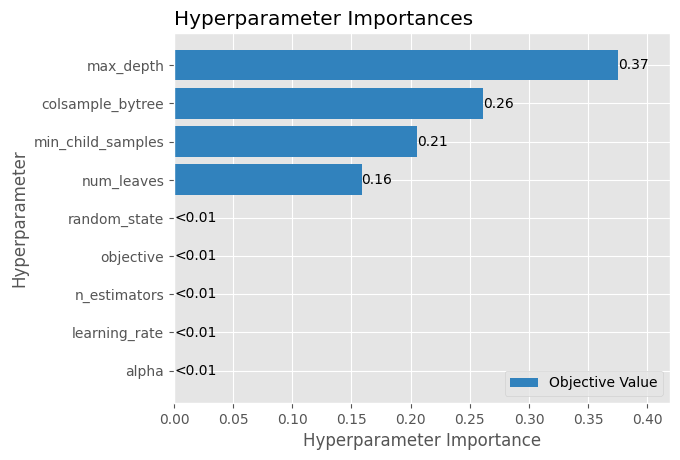

In [17]:
LGBM_1_bp = dict(study.best_params.items())

plot_param_importances(study);

Training the model with the obtained hyperparameters

In [18]:
cat_cols = list(cat_cols)

LightGBM_Tune_1 = LGBMRegressor(**LGBM_1_bp, verbosity=-1)

early_stopping_callback = early_stopping(stopping_rounds=100)

eval_set = [(X_val, y_val_1['price'])]

LightGBM_Tune_1.fit(X_train_,
                    y_train__1['price'],
                    eval_metric="l1",
                    eval_set=eval_set,
                    callbacks=[early_stopping_callback],
                    )

eval_set = [(X_val, y_val_1['price'])]

y_pred = LightGBM_Tune_1.predict(X_test)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1397]	valid_0's l1: 863143	valid_0's quantile: 431571


In [19]:
round(check_overfitting(LightGBM_Tune_1,
                        X_train_,
                        y_train__1['price'],
                        X_test,
                        y_test_1['price'],
                        metric_fun=mean_absolute_error,
                        target_name='price',
                        loss_fun='quantile'), 3)

,target_name,loss_fun,train,test,delta
0,price,quantile,800627.784,889874.528,10.029


In [20]:
metrics = get_metrics_regression(y_test=y_test_1['price'],
                                 y_pred=y_pred,
                                 X_test=X_test,
                                 name='LightGBM_Tune_1')

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,
LightGBM_Tune_1,889874.528,6.006059e+12,2450726.198,0.793,-4.819,13.954,10.954


#### Training with crossvalidation LightGBM_Tune_1
With the selected hyperparameters, train the model using crossvalidation to find the best parameters.

In [21]:
score_oof1, predictions_train1, predictions_test1, \
    LGBM_1 = cross_validation_regressor(X_train=X_train,
                                        y_train=y_train,
                                        X_test=X_test,
                                        y_test=y_test_1['price'],
                                        clf=lgb.LGBMRegressor,
                                        params=LGBM_1_bp,
                                        cat_features=None,
                                        eval_metric='mae',
                                        early_stop=False,
                                        early_stopping_rounds=100,
                                        num_folds=N_FOLDS,
                                        random_state=RAND)

Fold 1 Validation MAE: 889421.2879
Fold 2 Validation MAE: 929566.6071
Fold 3 Validation MAE: 940961.2197
Fold 4 Validation MAE: 916458.3584
Fold 5 Validation MAE: 928275.6673


In [22]:
print('MAE mean OOF: %.4f, std: %.2f' %
      (np.mean(score_oof1), np.std(score_oof1)))
print('MAE HOLDOUT: %.2f' % mean_absolute_error(y_test_1['price'], predictions_test1))

MAE mean OOF: 920936.6281, std: 17564.70
MAE HOLDOUT: 876787.96


In [23]:
metrics = pd.concat(
    [metrics, get_metrics_regression(y_test=y_test_1['price'],
                                     y_pred=predictions_test1,
                                     X_test=X_test,
                                     name='LGBM_1_HOLDOUT')
     ])

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,
LightGBM_Tune_1,889874.528,6.006059e+12,2450726.198,0.793,-4.819,13.954,10.954
LGBM_1_HOLDOUT,876787.958,6.078179e+12,2465396.348,0.790,-4.906,13.762,10.793


#### Calibration of the LightGBM_Tune_1 Model Using Isotonic Regression

After training with cross-validation, we will consider the possibility of using an additional calibrated model in stacking, calibrated using isotonic regression. We will perform the calibration and compare the metrics. Based on the results, a decision will be made regarding which model to use in the stacking process.

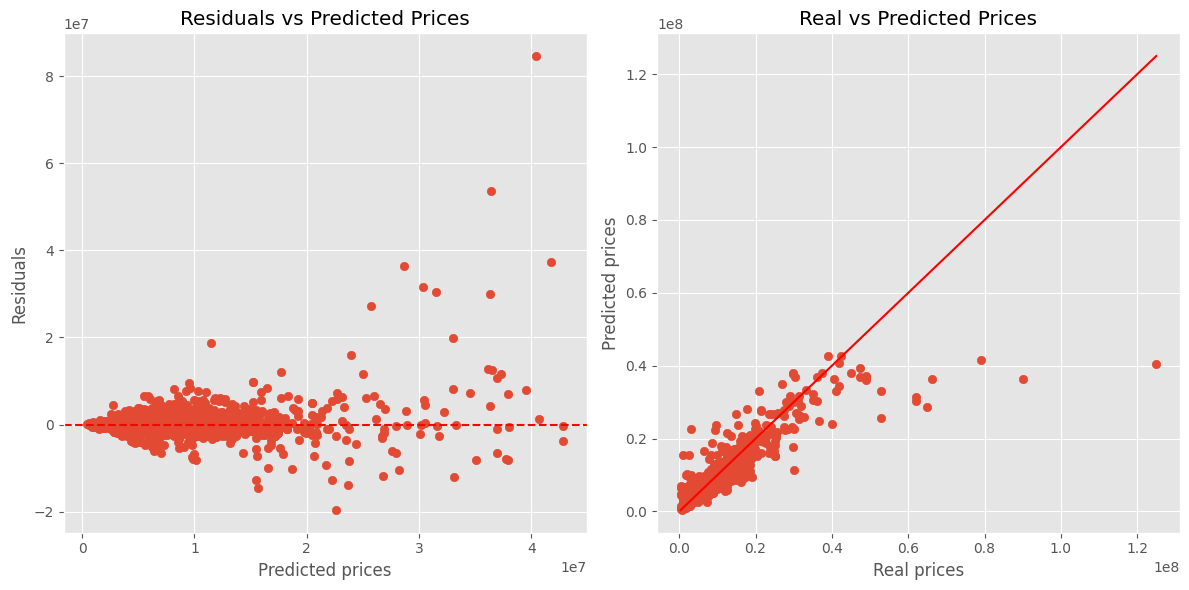

In [24]:
plot_residuals_vs_predictions(y_test_1['price'], predictions_test1)

In [25]:
# Performing isotonic calibration
calibrated_predictions_test1 = calibrate_predictions(
    predictions_train1, y_train, predictions_test1)

# Evaluation of the MAE metric on calibrated predictions
print('MAE HOLDOUT (calibrated): %.3f' %
      mean_absolute_error(y_test_1['price'], calibrated_predictions_test1))

MAE HOLDOUT (calibrated): 898526.811


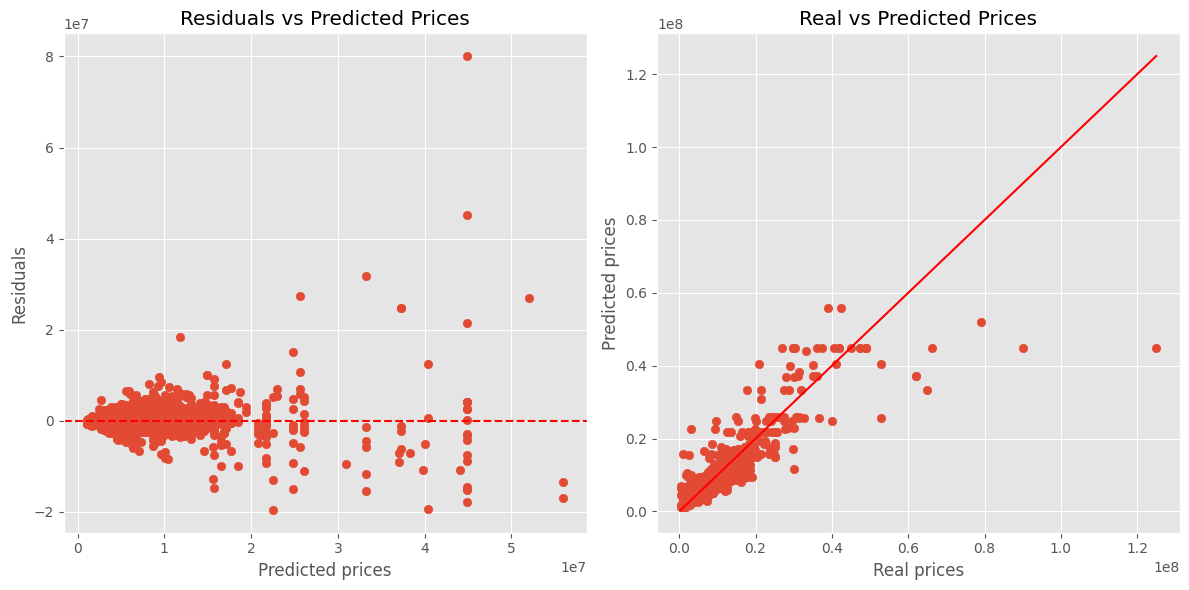

In [26]:
plot_residuals_vs_predictions(y_test_1['price'], calibrated_predictions_test1)

In [27]:
metrics = pd.concat(
    [metrics, get_metrics_regression(y_test=y_test_1['price'],
                                     y_pred=calibrated_predictions_test1,
                                     X_test=X_test,
                                     name='LightGBM_Tune_1_calibrated')
     ])

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,
LightGBM_Tune_1,889874.528,6.006059e+12,2450726.198,0.793,-4.819,13.954,10.954
LGBM_1_HOLDOUT,876787.958,6.078179e+12,2465396.348,0.790,-4.906,13.762,10.793
LightGBM_Tune_1_calibrated,898526.811,5.580876e+12,2362387.740,0.808,-5.852,14.183,11.060


### Second model LightGBM Tune 2

Let's do the same for the **LGBM Tune 2** model.

In [28]:
targets = ['price_log', 'price']

y = df[targets]

loss_funs = [
    {'objective': 'mae'},
    {'objective': 'huber', 'alpha': 3350000},
    {'objective': 'quantile', 'alpha': 0.51}
]

X_train, X_test, y_train, y_test_2 = train_test_split(X_lgbm_2,
                                                      y,
                                                      test_size=0.2,
                                                      shuffle=True,
                                                      random_state=RAND)

X_train_, X_val, y_train__2, y_val_2 = train_test_split(X_train,
                                                        y_train,
                                                        test_size=0.16,
                                                        shuffle=True,
                                                        random_state=RAND)

# Filling in the blanks
X_train = fill_missing_values(X_train, fill_dict_lgbm_2)
X_test = fill_missing_values(X_test, fill_dict_lgbm_2)
X_train_ = fill_missing_values(X_train_, fill_dict_lgbm_2)
X_val = fill_missing_values(X_val, fill_dict_lgbm_2)

overfitting = pd.DataFrame()


for target in targets:
    y_train_ = y_train__2[target]
    y_test = y_test_2[target]
    y_val = y_val_2[target]

    for loss_fun in loss_funs:

        early_stopping_callback = early_stopping(stopping_rounds=100)

        lgbm_base = LGBMRegressor(
            random_state=RAND, **loss_fun, verbosity=-1)

        eval_set = [(X_val, y_val)]

        lgbm_base.fit(X_train_,
                      y_train_,
                      eval_metric="mae",
                      eval_set=eval_set,
                      callbacks=[early_stopping_callback],
                      )

        if target == 'price_log':
            y_train_pl = np.exp(y_train_) - 1
            y_test_pl = np.exp(y_test) - 1
            print(target)
            overfitting = pd.concat(
                [overfitting, check_overfitting(lgbm_base,
                                                X_train_,
                                                y_train_pl,
                                                X_test,
                                                y_test_pl,
                                                metric_fun=mean_absolute_error,
                                                target_name=target,
                                                loss_fun=loss_fun.get('objective'))
                 ])

        if target != 'price_per_meter' and target != 'price_log':

            overfitting = pd.concat(
                [overfitting, check_overfitting(lgbm_base,
                                                X_train_,
                                                y_train_,
                                                X_test,
                                                y_test,
                                                metric_fun=mean_absolute_error,
                                                target_name=target,
                                                loss_fun=loss_fun.get('objective'))
                 ])

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.1434
price_log
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.143245	valid_0's huber: 0.024079
price_log
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.143034	valid_0's quantile: 0.0714437
price_log
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.20289e+06
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.22858e+06	valid_0's huber: 1.69926e+12
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.18479e+06	valid_0's quantile: 594640


In [29]:
round(overfitting.set_index('target_name'), 2)

,loss_fun,train,test,delta
target_name,,,,
price_log,mae,8121813.94,8124003.03,0.03
price_log,huber,8121813.94,8124003.03,0.03
price_log,quantile,8121813.94,8124003.03,0.03
price,mae,1088270.54,1170777.11,7.05
price,huber,1123597.89,1203817.07,6.66
price,quantile,1080776.03,1163648.27,7.12


The minimum error on **train** and **test** was obtained using the target variable **price** and the loss function **quantile** as for the **LGBM Tune 1** model.

Split the dataset into test, train, and val.

In [30]:
# target function
def objective_lgb(trial, X, y, N_FOLDS, random_state=RAND):
    lgb_params = {
        # "n_estimators": trial.suggest_int("n_estimators", 800, 3000, step=50),
        "n_estimators": trial.suggest_categorical("n_estimators", [1200]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.04974513748577575]),
        # "learning_rate": trial.suggest_float("learning_rate",
        #                                      0.001,
        #                                      0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 30, 40, step=1),
        "max_depth": trial.suggest_int("max_depth", 9, 10),
        # "max_bin": trial.suggest_int("max_bin", 512, 2048),
        "min_child_samples": trial.suggest_int("min_child_samples", 16, 22, step=1),
        "reg_alpha": trial.suggest_int("reg_alpha", 10, 20),
        # "reg_lambda": trial.suggest_int("reg_lambda", 70, 100),
        # "min_split_gain": trial.suggest_int("min_split_gain", 0, 20),
        "subsample": trial.suggest_float("subsample", 0.2, 0.9),
        # "subsample_freq": trial.suggest_categorical("subsample_freq", [1]),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
        "objective": trial.suggest_categorical("objective", ['quantile']),
        "alpha": trial.suggest_categorical("alpha", [0.51]),
        "random_state": trial.suggest_categorical("random_state", [random_state])
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True)
    early_stopping_callback = early_stopping(stopping_rounds=100)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "l1")
        model = LGBMRegressor(**lgb_params, verbosity=-1)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="mae",
                  callbacks=[pruning_callback, early_stopping_callback],
                  )

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [31]:
y_train = y_train['price']

study = optuna.create_study(direction="minimize", study_name="LightGBM_Tune_2",
                            sampler=optuna.samplers.TPESampler(seed=RAND))


def func(trial): return objective_lgb(
    trial, X_train, y_train, N_FOLDS=N_FOLDS, random_state=RAND)


optuna.logging.set_verbosity(optuna.logging.CRITICAL)
study.optimize(func, n_trials=7, show_progress_bar=True)

  0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1052]	valid_0's l1: 1.13044e+06	valid_0's quantile: 567198
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[685]	valid_0's l1: 1.16142e+06	valid_0's quantile: 583217
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[832]	valid_0's l1: 1.19146e+06	valid_0's quantile: 598671
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[522]	valid_0's l1: 1.13256e+06	valid_0's quantile: 568485
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1197]	valid_0's l1: 1.12481e+06	valid_0's quantile: 564745
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[516]	valid_0's l1: 1.17482e+06	valid_0's quantile: 590082
Training until validation scores don't improve fo

In [32]:
print(f"\tBest value (mae): {study.best_value:.6f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (mae): 1148139.630910
	Best params:
		n_estimators: 1200
		learning_rate: 0.04974513748577575
		num_leaves: 39
		max_depth: 10
		min_child_samples: 17
		reg_alpha: 12
		subsample: 0.4877700895475792
		colsample_bytree: 0.6352126641404147
		objective: quantile
		alpha: 0.51
		random_state: 25


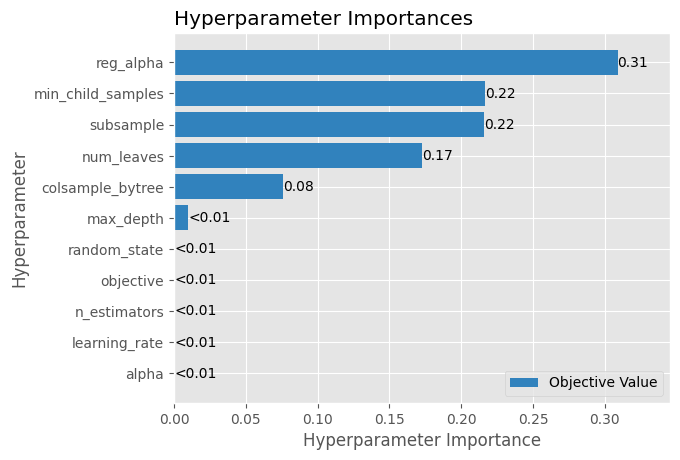

In [33]:
LGBM_2_bp = dict(study.best_params.items())

plot_param_importances(study);

In [34]:
LightGBM_Tune_2 = LGBMRegressor(**LGBM_2_bp, verbosity=-1)

early_stopping_callback = early_stopping(stopping_rounds=100)

eval_set = [(X_val, y_val)]

LightGBM_Tune_2.fit(X_train_[features_lgbm_2],
                    y_train_,
                    eval_metric="mae",
                    eval_set=eval_set,
                    callbacks=[early_stopping_callback],
                    )

eval_set = [(X_val, y_val)]

y_pred = LightGBM_Tune_2.predict(X_test)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1190]	valid_0's l1: 1.15917e+06	valid_0's quantile: 581497


In [35]:
round(check_overfitting(LightGBM_Tune_2,
                        X_train_,
                        y_train__2['price'],
                        X_test,
                        y_test_2['price'],
                        metric_fun=mean_absolute_error,
                        target_name='price',
                        loss_fun='quantile'), 3)

,target_name,loss_fun,train,test,delta
0,price,quantile,1025104.82,1133782.088,9.585


In [36]:
metrics = pd.concat(
    [metrics, get_metrics_regression(y_test=y_test_2['price'],
                                     y_pred=y_pred,
                                     X_test=X_test,
                                     name='LightGBM_Tune_2')
     ])

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,
LightGBM_Tune_1,889874.528,6.006059e+12,2450726.198,0.793,-4.819,13.954,10.954
LGBM_1_HOLDOUT,876787.958,6.078179e+12,2465396.348,0.790,-4.906,13.762,10.793
LightGBM_Tune_1_calibrated,898526.811,5.580876e+12,2362387.740,0.808,-5.852,14.183,11.060
LightGBM_Tune_2,1133782.088,8.954900e+12,2992473.964,0.691,-4.871,15.781,13.956


In [37]:
score_oof2, predictions_train2, predictions_test2, \
    LGBM_2 = cross_validation_regressor(X_train=X_train,
                                        y_train=y_train,
                                        X_test=X_test,
                                        y_test=y_test_2['price'],
                                        clf=lgb.LGBMRegressor,
                                        params=LGBM_2_bp,
                                        cat_features=None,
                                        eval_metric='mae',
                                        early_stop=False,
                                        early_stopping_rounds=100,
                                        num_folds=N_FOLDS,
                                        random_state=RAND)

Fold 1 Validation MAE: 1168374.9790
Fold 2 Validation MAE: 1134951.7036
Fold 3 Validation MAE: 1180546.6849
Fold 4 Validation MAE: 1147107.7107
Fold 5 Validation MAE: 1145535.9752


In [38]:
print('MAE mean OOF: %.2f, std: %.2f' %
      (np.mean(score_oof2), np.std(score_oof2)))
print('MAE HOLDOUT: %.2f' % mean_absolute_error(
    y_test_2['price'], predictions_test2))

MAE mean OOF: 1155303.41, std: 16642.43
MAE HOLDOUT: 1140721.59


In [39]:
metrics = pd.concat(
    [metrics, get_metrics_regression(y_test=y_test_2['price'],
                                     y_pred=predictions_test2,
                                     X_test=X_test,
                                     name='LGBM_2_HOLDOUT')
     ])

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,
LightGBM_Tune_1,889874.528,6.006059e+12,2450726.198,0.793,-4.819,13.954,10.954
LGBM_1_HOLDOUT,876787.958,6.078179e+12,2465396.348,0.790,-4.906,13.762,10.793
LightGBM_Tune_1_calibrated,898526.811,5.580876e+12,2362387.740,0.808,-5.852,14.183,11.060
LightGBM_Tune_2,1133782.088,8.954900e+12,2992473.964,0.691,-4.871,15.781,13.956
LGBM_2_HOLDOUT,1140721.591,9.437304e+12,3072019.516,0.674,-4.853,15.733,14.041


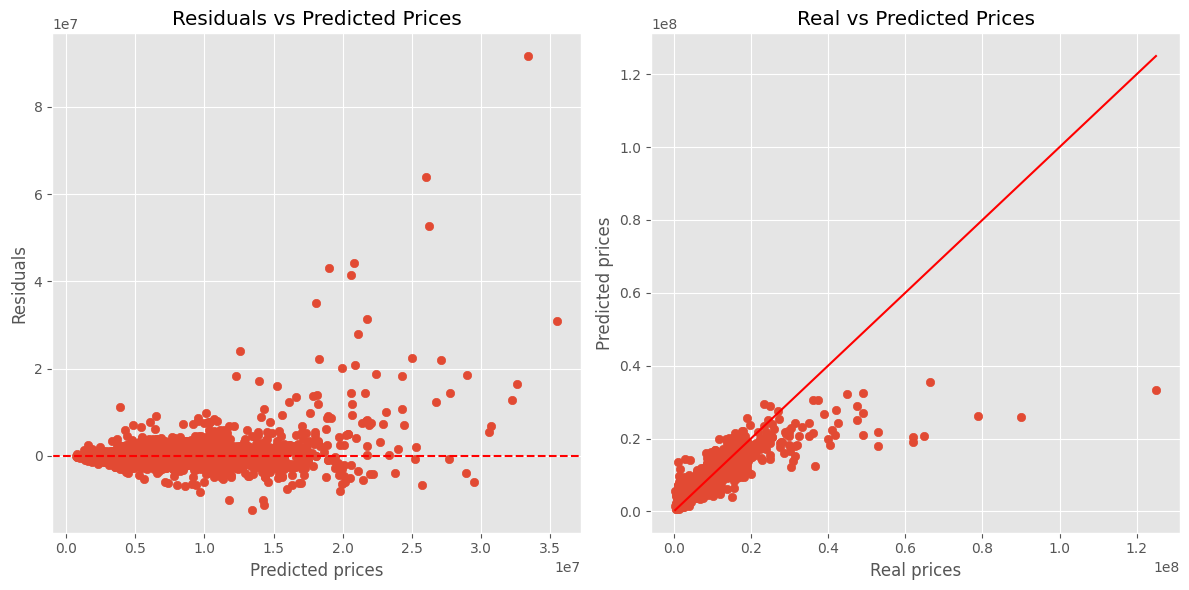

In [40]:
plot_residuals_vs_predictions(y_test_2['price'], predictions_test2)

In [41]:
# Performing isotonic calibration
calibrated_predictions_test2 = calibrate_predictions(
    predictions_train2, y_train, predictions_test2)

# Evaluation of the MAE metric on calibrated predictions
print('MAE HOLDOUT (calibrated): %.2f' %
      mean_absolute_error(y_test_2['price'], calibrated_predictions_test2))

MAE HOLDOUT (calibrated): 1125607.04


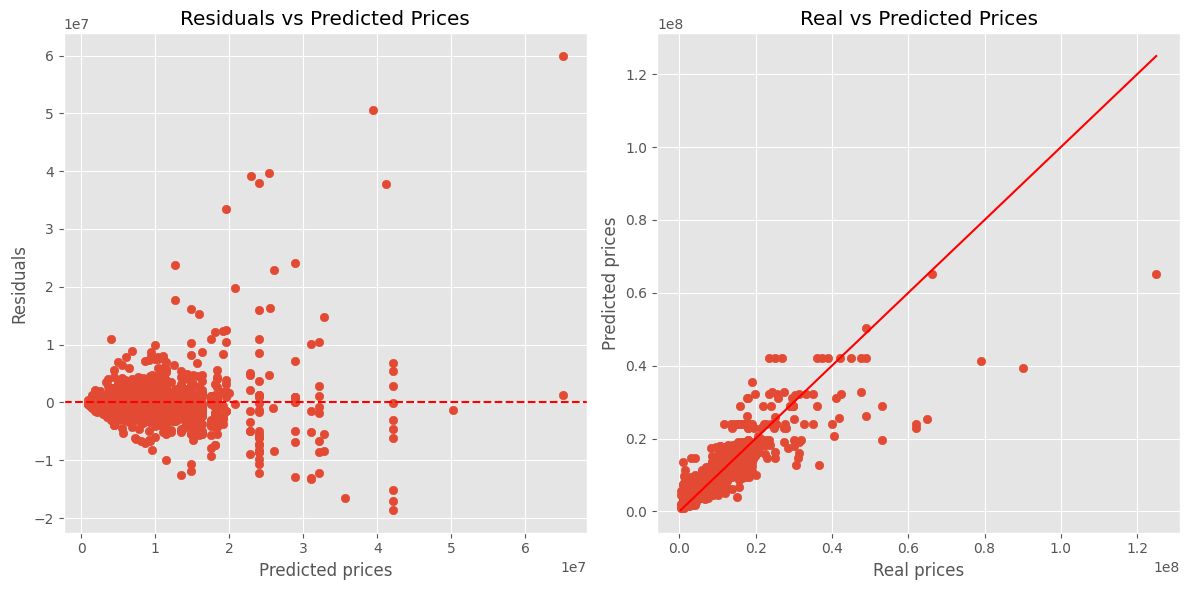

In [42]:
plot_residuals_vs_predictions(y_test_2['price'], calibrated_predictions_test2)

In [43]:
metrics = pd.concat(
    [metrics, get_metrics_regression(y_test=y_test_2['price'],
                                     y_pred=calibrated_predictions_test2,
                                     X_test=X_test,
                                     name='LightGBM_Tune_2_calibrated')
     ])

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,
LightGBM_Tune_1,889874.528,6.006059e+12,2450726.198,0.793,-4.819,13.954,10.954
LGBM_1_HOLDOUT,876787.958,6.078179e+12,2465396.348,0.790,-4.906,13.762,10.793
LightGBM_Tune_1_calibrated,898526.811,5.580876e+12,2362387.740,0.808,-5.852,14.183,11.060
LightGBM_Tune_2,1133782.088,8.954900e+12,2992473.964,0.691,-4.871,15.781,13.956
LGBM_2_HOLDOUT,1140721.591,9.437304e+12,3072019.516,0.674,-4.853,15.733,14.041
LightGBM_Tune_2_calibrated,1125607.043,6.856497e+12,2618491.307,0.763,-6.680,16.285,13.855


### Third CatBoost model

We will also train baseline models with loss functions that are less sensitive to non-normal distributions compared to MSE. Subsequently, we will optimize the best hyperparameters using randomized_search.

In [44]:
cat_cols = list(cat_cols)

In [45]:
X = df.drop(['price', 'price_log', 'price_per_meter'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    random_state=RAND)

# Filling in the blanks
X_train = fill_missing_values(X_train, fill_dict)
X_test = fill_missing_values(X_test, fill_dict)
X_train_ = fill_missing_values(X_train_, fill_dict)
X_val = fill_missing_values(X_val, fill_dict)

In [46]:
loss_funs = ['MAE', 'RMSE', 'LogCosh']

overfitting_cb = pd.DataFrame()

cat_cols = list(cat_cols)

for loss_fun in loss_funs:
    cb_base = CatBoostRegressor(allow_writing_files=False,
                                loss_function=loss_fun,
                                random_state=RAND,
                                eval_metric=loss_fun,
                                cat_features=cat_cols)
    eval_set = [(X_val, y_val)]

    cb_base.fit(X_train_,
                y_train_,
                eval_set=eval_set,
                verbose=False,
                early_stopping_rounds=100)

    overfitting_cb = pd.concat(
        [overfitting_cb, check_overfitting(cb_base,
                                           X_train_,
                                           y_train_,
                                           X_test,
                                           y_test,
                                           metric_fun=mean_absolute_error,
                                           target_name=target,
                                           loss_fun=loss_fun)
         ])

round(overfitting_cb.set_index('target_name'), 2)

,loss_fun,train,test,delta
target_name,,,,
price,MAE,678181.91,739216.45,8.26
price,RMSE,603471.67,732656.43,17.63
price,LogCosh,686730.93,742383.70,7.50


In [47]:
grid = {
    'iterations': [1300],
    'learning_rate': [0.043444122987293665],
    'random_seed': [RAND],
    'random_strength': [110, 120, 130],
    # 'l2_leaf_reg': [35],
    'depth': [6],
    'max_leaves': [62, 64, 66],
    "bootstrap_type": ["Bayesian", "Bernoulli", "MVS"],
    'rsm': [0.5, 0.7, 0.8, 1],
    'bagging_temperature': [0.2, 0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
}

In [48]:
# Creating Pool objects for CatBoost with specified categorical features
train_pool = Pool(X_train_, y_train_, cat_features=cat_cols)
eval_pool = Pool(X_val, y_val, cat_features=cat_cols)

# Defining the CatBoostRegressor model
cat_rand = CatBoostRegressor(
    loss_function='MAE',  # Loss function
    eval_metric='MAE',  # Metric for model evaluation
    cat_features=cat_cols,  # Categorical features
    silent=True  # Suppress output
)

# Performing randomized search for hyperparameter tuning
grid_search_result = cat_rand.randomized_search(
    grid,  # Parameter grid
    X=train_pool,  # Training data
    y=None,  # y is not needed as it's already specified in the Pool
    cv=5,  # Number of folds for cross-validation
    n_iter=30,  # Number of search iterations
    partition_random_seed=RAND,  # Random partitioning of data
    calc_cv_statistics=True,  # Calculate cross-validation statistics
    search_by_train_test_split=True,  # Use train-test split
    refit=True,  # Refit the model after the search
    shuffle=True,  # Shuffle the data
    stratified=False,  # Stratification is not required for regression
    verbose=False,  # Suppress output
    plot=False,  # Disable hyperparameter search plotting
)


bestTest = 718502.4727
bestIteration = 1295


bestTest = 714730.7077
bestIteration = 1298


bestTest = 716218.7784
bestIteration = 1299

Training on fold [0/5]

bestTest = 758789.0197
bestIteration = 1299

Training on fold [1/5]

bestTest = 755344.8916
bestIteration = 1299

Training on fold [2/5]

bestTest = 817500.6072
bestIteration = 1299

Training on fold [3/5]

bestTest = 712658.9994
bestIteration = 1299

Training on fold [4/5]

bestTest = 705319.5067
bestIteration = 1299



In [49]:
CatBstParams = grid_search_result['params']
CatBstParams

{'max_leaves': 64,
 'rsm': 0.7,
 'random_strength': 110,
 'bootstrap_type': 'MVS',
 'iterations': 1300,
 'bagging_temperature': 0.2,
 'subsample': 0.8,
 'depth': 6,
 'learning_rate': 0.043444122987293665,
 'random_seed': 25}

In [50]:
round(check_overfitting(cat_rand,
                        X_train_,
                        y_train_,
                        X_test,
                        y_test,
                        metric_fun=mean_absolute_error,
                        target_name='price',
                        loss_fun='MAE'), 2)

,target_name,loss_fun,train,test,delta
0,price,MAE,649625.05,720007.73,9.78


In [51]:
y_pred = cat_rand.predict(X_test)
metrics = pd.concat(
    [metrics, get_metrics_regression(y_test=y_test,
                                     y_pred=y_pred,
                                     X_test=X_test,
                                     name='CatBoost_Tune')
     ])

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,
LightGBM_Tune_1,889874.528,6.006059e+12,2450726.198,0.793,-4.819,13.954,10.954
LGBM_1_HOLDOUT,876787.958,6.078179e+12,2465396.348,0.790,-4.906,13.762,10.793
LightGBM_Tune_1_calibrated,898526.811,5.580876e+12,2362387.740,0.808,-5.852,14.183,11.060
LightGBM_Tune_2,1133782.088,8.954900e+12,2992473.964,0.691,-4.871,15.781,13.956
LGBM_2_HOLDOUT,1140721.591,9.437304e+12,3072019.516,0.674,-4.853,15.733,14.041
LightGBM_Tune_2_calibrated,1125607.043,6.856497e+12,2618491.307,0.763,-6.680,16.285,13.855
CatBoost_Tune,720007.732,4.437468e+12,2106529.903,0.847,-2.625,10.257,8.863


##### Training with cross validation

To identify the best parameters, we will conduct training with cross-validation using the discovered parameters. Additionally, we will apply isotonic calibration and select models for stacking based on the resulting metrics.

In [52]:
score_oof3, predictions_train3, \
    predictions_test3, CatBst = cross_validation_regressor(X_train=X_train,
                                                           y_train=y_train,
                                                           X_test=X_test,
                                                           y_test=y_test,
                                                           clf=CatBoostRegressor,
                                                           params=CatBstParams,
                                                           cat_features=cat_cols,
                                                           eval_metric='mae',
                                                           early_stop=False,
                                                           early_stopping_rounds=100,
                                                           num_folds=N_FOLDS,
                                                           random_state=RAND);

Fold 1 Validation MAE: 773341.6635
Fold 2 Validation MAE: 801914.7024
Fold 3 Validation MAE: 802537.8424
Fold 4 Validation MAE: 795571.7903
Fold 5 Validation MAE: 788347.0162


In [53]:
test_pred3 = predictions_test3

print('MAE mean OOF: %.4f, std: %.4f' %
      (np.mean(score_oof3), np.std(score_oof3)))

print('MAE HOLDOUT: %.4f' % mean_absolute_error(y_test, test_pred3))

MAE mean OOF: 792342.6030, std: 10798.1115
MAE HOLDOUT: 817362.0949


In [54]:
metrics = pd.concat(
    [metrics, get_metrics_regression(y_test=y_test,
                                     y_pred=predictions_test3,
                                     X_test=X_test,
                                     name='CatBoost_HOLDOUT')
     ])

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,
LightGBM_Tune_1,889874.528,6.006059e+12,2450726.198,0.793,-4.819,13.954,10.954
LGBM_1_HOLDOUT,876787.958,6.078179e+12,2465396.348,0.790,-4.906,13.762,10.793
LightGBM_Tune_1_calibrated,898526.811,5.580876e+12,2362387.740,0.808,-5.852,14.183,11.060
LightGBM_Tune_2,1133782.088,8.954900e+12,2992473.964,0.691,-4.871,15.781,13.956
LGBM_2_HOLDOUT,1140721.591,9.437304e+12,3072019.516,0.674,-4.853,15.733,14.041
LightGBM_Tune_2_calibrated,1125607.043,6.856497e+12,2618491.307,0.763,-6.680,16.285,13.855
CatBoost_Tune,720007.732,4.437468e+12,2106529.903,0.847,-2.625,10.257,8.863
CatBoost_HOLDOUT,817362.095,3.735940e+12,1932858.025,0.871,-1.887,11.580,10.061


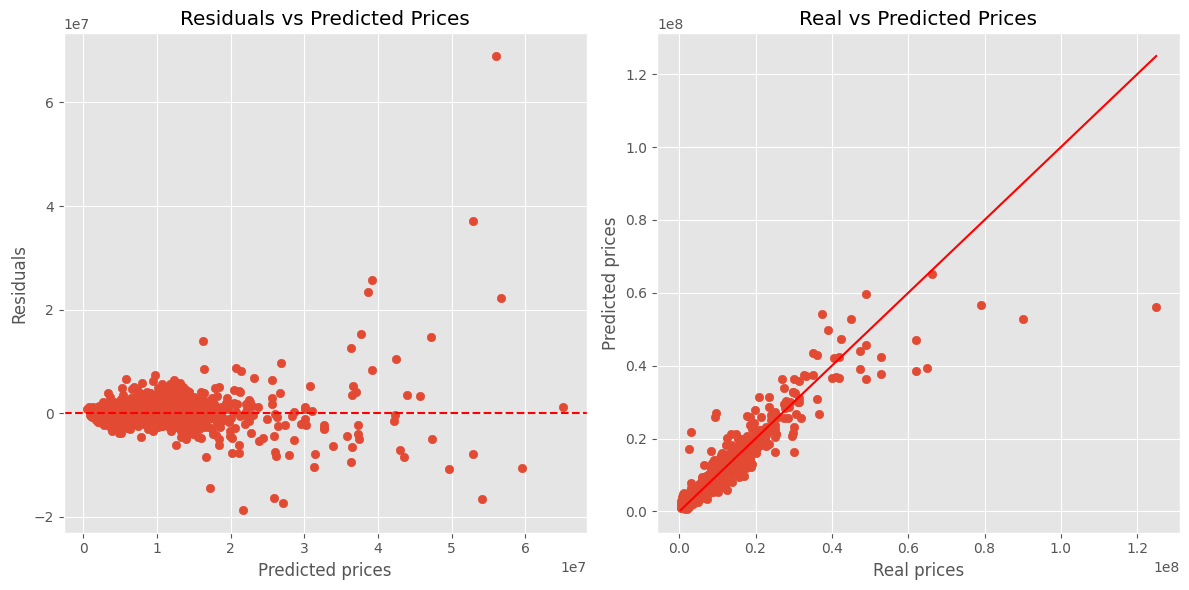

In [55]:
plot_residuals_vs_predictions(y_test, predictions_test3)

In [56]:
# Performing isotonic calibration
calibrated_predictions_test3 = calibrate_predictions(
    predictions_train3, y_train, predictions_test3)

# Evaluation of the MAE metric on calibrated predictions
print('MAE HOLDOUT (calibrated): %.4f' %
      mean_absolute_error(y_test, calibrated_predictions_test3))

MAE HOLDOUT (calibrated): 821341.8404


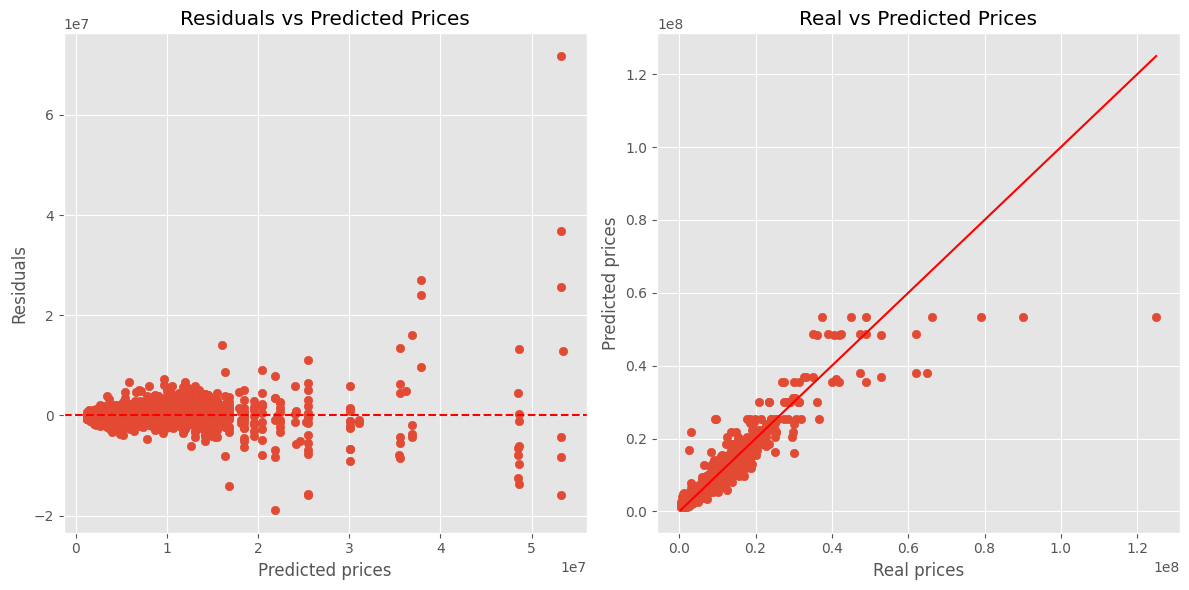

In [57]:
plot_residuals_vs_predictions(y_test, calibrated_predictions_test3)

In [58]:
metrics = pd.concat(
    [metrics, get_metrics_regression(y_test=y_test,
                                     y_pred=calibrated_predictions_test3,
                                     X_test=X_test,
                                     name='CatBoost_calibrated')
     ])

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,
LightGBM_Tune_1,889874.528,6.006059e+12,2450726.198,0.793,-4.819,13.954,10.954
LGBM_1_HOLDOUT,876787.958,6.078179e+12,2465396.348,0.790,-4.906,13.762,10.793
LightGBM_Tune_1_calibrated,898526.811,5.580876e+12,2362387.740,0.808,-5.852,14.183,11.060
LightGBM_Tune_2,1133782.088,8.954900e+12,2992473.964,0.691,-4.871,15.781,13.956
LGBM_2_HOLDOUT,1140721.591,9.437304e+12,3072019.516,0.674,-4.853,15.733,14.041
LightGBM_Tune_2_calibrated,1125607.043,6.856497e+12,2618491.307,0.763,-6.680,16.285,13.855
CatBoost_Tune,720007.732,4.437468e+12,2106529.903,0.847,-2.625,10.257,8.863
CatBoost_HOLDOUT,817362.095,3.735940e+12,1932858.025,0.871,-1.887,11.580,10.061
CatBoost_calibrated,821341.840,3.917388e+12,1979239.186,0.865,-1.984,11.610,10.110


### Comparison of Results:

**LightGBM_Tune_1:**

- After cross-validation (LGBM_1_HOLDOUT):
  - MAE = 876787.958
  - MSE = 6.078179e+12
  - RMSE = 2465396.348
  - R² adjusted = 0.790
  - MPE_% = -4.906
  - MAPE_% = 13.762
  - WAPE_% = 10.793

- After isotonic calibration (LightGBM_Tune_1_calibrated):
  - MAE = 898526.811 (increase)
  - MSE = 5.580876e+12 (improvement)
  - RMSE = 2362387.740 (improvement)
  - R² adjusted = 0.808 (improvement)
  - MPE_% = -5.852 (deterioration)
  - MAPE_% = 14.183 (deterioration)
  - WAPE_% = 11.060 (deterioration)

**Conclusion**: Isotonic calibration improved the MSE, RMSE, and R² adjusted metrics for LightGBM_Tune_1 but slightly increased MAE and worsened percentage-based error metrics (MPE_%, MAPE_%, WAPE_%). The calibrated model may be useful if RMSE and R² are prioritized.

---

**LightGBM_Tune_2:**

- After cross-validation (LGBM_2_HOLDOUT):
  - MAE = 1140721.591
  - MSE = 9.437304e+12
  - RMSE = 3072019.516
  - R² adjusted = 0.674
  - MPE_% = -4.853
  - MAPE_% = 15.733
  - WAPE_% = 14.041

- After isotonic calibration (LightGBM_Tune_2_calibrated):
  - MAE = 1125607.043 (improvement)
  - MSE = 6.856497e+12 (improvement)
  - RMSE = 2618491.307 (improvement)
  - R² adjusted = 0.763 (improvement)
  - MPE_% = -6.680 (deterioration)
  - MAPE_% = 16.285 (deterioration)
  - WAPE_% = 13.855 (improvement)

**Conclusion**: Calibration led to improvements in MSE, RMSE, and R² adjusted metrics for LightGBM_Tune_2 but slightly worsened MPE_% and MAPE_%. Based on this, the calibrated version of LightGBM_Tune_2 may be preferred for better accuracy in RMSE and R².

---

**CatBoost:**

- After cross-validation (CatBoost_HOLDOUT):
  - MAE = 817362.095
  - MSE = 3.735940e+12
  - RMSE = 1932858.025
  - R² adjusted = 0.871
  - MPE_% = -1.887
  - MAPE_% = 11.580
  - WAPE_% = 10.061

- After isotonic calibration (CatBoost_calibrated):
  - MAE = 821341.840 (no significant change)
  - MSE = 3.917388e+12 (minimal deterioration)
  - RMSE = 1979239.186 (minimal deterioration)
  - R² adjusted = 0.865 (slight decrease)
  - MPE_% = -1.984 (slight deterioration)
  - MAPE_% = 11.610 (no significant change)
  - WAPE_% = 10.110 (no significant change)

**Conclusion**: For CatBoost, calibration had little to no impact on metrics, indicating the model's stability without calibration. The original version after cross-validation can be used.

---

**Final Conclusion**:
- **LightGBM_Tune_1** shows improvements after isotonic calibration compared to the uncalibrated model after cross-validation. The calibrated version should be used in stacking.
- **LightGBM_Tune_2** also demonstrates improvements in RMSE and R² metrics after calibration, although MAPE_% slightly increases. The calibrated version is recommended for stacking.
- **CatBoost** exhibits nearly identical results before and after calibration. The uncalibrated version after cross-validation is preferable.

Therefore, in stacking, it is advisable to use the calibrated versions of **LightGBM_Tune_1** and **LightGBM_Tune_2**, while the uncalibrated version of **CatBoost** should be selected.

## Stacking

Stacking will be performed in two variations:  

1) **First variation**:  
   - For comparison, we will use all models without calibration.  

2) **Second variation**:  
   - Based on the analysis of metrics from the previous section, using the **calibrated LightGBM_Tune_1** and **calibrated LightGBM_Tune_2**, while for **CatBoost**, we will use the versions after cross-validation.  

In [59]:
from sklearn.utils.fixes import sp_version, parse_version
trained_models = [CatBst, LGBM_1, LGBM_2]  # модели для стекинга

meta_model2 = QuantileRegressor(quantile=0.56, alpha=0)

feature_sets = [X.columns, features_lgbm_1,
                features_lgbm_2]  # наборы признаков
cat_features_sets = cat_cols  # Категориальные признаки только для CatBoost

calibration_methods = [None, None, None]  # метод калибровки

stacking_model1 = StackingRegressorCV(
    trained_models, meta_model2, feature_sets, calibration_methods=calibration_methods)

stacking_model1.fit_meta_model(X_train, y_train)

y_pred = stacking_model1.predict(X_test)

# Оцениваем качество модели
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE on the test sample: %.4f" % mae)

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
MAE on the test sample: 832554.4870


In [60]:
round(check_overfitting(stacking_model1,
                  X_train_,
                  y_train_,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error,
                  target_name='price',
                  loss_fun='quantile'), 3)

,target_name,loss_fun,train,test,delta
0,price,quantile,770932.186,832554.487,7.402


In [61]:
metrics = pd.concat(
    [metrics, get_metrics_regression(y_test=y_test,
                                     y_pred=y_pred,
                                     X_test=X_test,
                                     name='Stacking_model')
     ])

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,
LightGBM_Tune_1,889874.528,6.006059e+12,2450726.198,0.793,-4.819,13.954,10.954
LGBM_1_HOLDOUT,876787.958,6.078179e+12,2465396.348,0.790,-4.906,13.762,10.793
LightGBM_Tune_1_calibrated,898526.811,5.580876e+12,2362387.740,0.808,-5.852,14.183,11.060
LightGBM_Tune_2,1133782.088,8.954900e+12,2992473.964,0.691,-4.871,15.781,13.956
LGBM_2_HOLDOUT,1140721.591,9.437304e+12,3072019.516,0.674,-4.853,15.733,14.041
LightGBM_Tune_2_calibrated,1125607.043,6.856497e+12,2618491.307,0.763,-6.680,16.285,13.855
CatBoost_Tune,720007.732,4.437468e+12,2106529.903,0.847,-2.625,10.257,8.863
CatBoost_HOLDOUT,817362.095,3.735940e+12,1932858.025,0.871,-1.887,11.580,10.061
CatBoost_calibrated,821341.840,3.917388e+12,1979239.186,0.865,-1.984,11.610,10.110


In [62]:
trained_models = [CatBst, LGBM_1, LGBM_2]  # модели для стекинга

meta_model = QuantileRegressor(quantile=0.55, alpha=0)

feature_sets = [X.columns, features_lgbm_1, features_lgbm_2]

cat_features_sets = cat_cols  # Категориальные признаки только для CatBoost

calibration_methods = [None, 'isotonic', 'isotonic']  # метод калибровки

stacking_model0 = StackingRegressorCV(
    trained_models, meta_model, feature_sets, calibration_methods=calibration_methods)
stacking_model0.fit_meta_model(X_train, y_train)

y_pred = stacking_model0.predict(X_test)

# Оцениваем качество модели
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE on the test sample: %.2f" % mae)

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
MAE on the test sample: 838672.58


In [63]:
round(check_overfitting(stacking_model0,
                        X_train_,
                        y_train_,
                        X_test,
                        y_test,
                        metric_fun=mean_absolute_error,
                        target_name='price',
                        loss_fun='quantile'), 3)

,target_name,loss_fun,train,test,delta
0,price,quantile,768737.489,838672.575,8.339


In [64]:
metrics = pd.concat(
    [metrics, get_metrics_regression(y_test=y_test,
                                     y_pred=y_pred,
                                     X_test=X_test,
                                     name='Stacking_model_calibrated')
     ])

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,
LightGBM_Tune_1,889874.528,6.006059e+12,2450726.198,0.793,-4.819,13.954,10.954
LGBM_1_HOLDOUT,876787.958,6.078179e+12,2465396.348,0.790,-4.906,13.762,10.793
LightGBM_Tune_1_calibrated,898526.811,5.580876e+12,2362387.740,0.808,-5.852,14.183,11.060
LightGBM_Tune_2,1133782.088,8.954900e+12,2992473.964,0.691,-4.871,15.781,13.956
LGBM_2_HOLDOUT,1140721.591,9.437304e+12,3072019.516,0.674,-4.853,15.733,14.041
LightGBM_Tune_2_calibrated,1125607.043,6.856497e+12,2618491.307,0.763,-6.680,16.285,13.855
CatBoost_Tune,720007.732,4.437468e+12,2106529.903,0.847,-2.625,10.257,8.863
CatBoost_HOLDOUT,817362.095,3.735940e+12,1932858.025,0.871,-1.887,11.580,10.061
CatBoost_calibrated,821341.840,3.917388e+12,1979239.186,0.865,-1.984,11.610,10.110


The final analysis of the models shows that the stacking models (`Stacking_model_calibrated` and `Stacking_model`) generally demonstrate strong results compared to the LightGBM models.  

### Final Conclusions:
- **The stacking model** delivers solid results, showing improvement in RMSE and MAE metrics compared to the LightGBM models, while not significantly lagging behind the CatBoost models. This makes it a strong candidate for use, as it combines the best characteristics of both models.
- **CatBoost_Tune** remains the strongest in explanatory power (R²) and demonstrates low MAPE and WAPE values, indicating high accuracy and stability. This result can be considered if explanatory power and accuracy on individual values are crucial.

Thus, as the final model, it is reasonable to use **the stacking model** (e.g., `Stacking_model`), which showed good overall results across the MAE, MSE, and RMSE metrics.  